
![title](https://www.geek.com/wp-content/uploads/2018/07/amazon-625x352.jpg)

# Detect Spam Reviewers on Amazon Datasets

The widespread of the fake reviews in the online reviews system could be a problem for normal customers to make the right purchase decisions. Here we utilize the statistical model to study the behavioral patterns of spam reviewers and use clustering algorithms to distinguish the potential spam and normal reviewers. The case study on selected Amazon review dataset shows that there is a large proportion of spam reviewers in Amazon users and they may have a strong impact on the online reviews system.


## Data Selection: Categories And Size
For practical reason and limited storage, we would like to experiment with the selected categories data as follows (contains both reviews and the product metadata):

- Home and Kitchen:
  - Review data: 5-core, 551,682 reviews
  - Metadata: 436,988 products

In our research, those products and users that have only few reviews can not help us to find out the regulation of fake reviews therefore we only chose the dataset in which each of the reviewers and products have at least 5 reviews, called 5-core dataset.



## Amazon Review Datasets Introduction

This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.

This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).
Link for amazon review datasets:http://jmcauley.ucsd.edu/data/amazon/links.html

# Data Loading

In [125]:
import pandas as pd
import gzip
import time 
import pickle
import warnings
import collections
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from datetime import date
from datetime import datetime
import spacy
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
warnings.filterwarnings('ignore')
# load pretrained models
nlp = spacy.load('en')
# convert unixtimestamp
f = datetime.utcfromtimestamp

In [2]:
# define a function to load the data
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

getDF('reviews_Home_and_Kitchen.json.gz').to_csv('./home_reviews.csv')
getDF('meta_Home_and_Kitchen.json.gz').to_csv('./home_meta.csv')

In [3]:
# use the function above to load the data and saved as csv files that we can directly use

#Home and Kitchen
home_reviews_raw = pd.read_csv('./home_reviews.csv')
home_meta_raw = pd.read_csv('./home_meta.csv')

# Data Initial Observation

#### Review Data:

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

#### Meta Data:

- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to

In [4]:
# Data Initial Observation
home_reviews_raw.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


In [5]:
home_meta_raw.head(5)

,asin,salesRank,imUrl,categories,title,description,related,price,brand
0,0076144011,{'Books': 6285595},http://g-ecx.images-amazon.com/images/G/01/x-s...,[['Home & Kitchen']],"Ninjas, Piranhas, and Galileo",NaN,NaN,NaN,NaN
1,0130350591,{'Kitchen & Dining': 459680},http://ecx.images-amazon.com/images/I/21zcx6RC...,"[['Home & Kitchen', 'Kitchen & Dining', 'Dinin...",Le Creuset Kiwi (Green) Butter Dish Stoneware,Each piece of Le Creuset dinnerware is crafted...,NaN,NaN,NaN
2,0307394530,"{'Arts, Crafts & Sewing': 3597}",http://ecx.images-amazon.com/images/I/51A4FWuj...,"[['Home & Kitchen', 'Artwork', 'Posters & Prin...",Martha Stewart's Wedding Cakes,Of all the decisions that go into planning a w...,"{'also_bought': ['144630163X', '1402717733', '...",14.99,Random House
3,0439903491,{'Software': 7065},http://ecx.images-amazon.com/images/I/61tVxcko...,"[['Home & Kitchen', 'Artwork', 'Posters & Prin...",NaN,Shiver me timbers! Solve I SPY pirate picture ...,"{'also_viewed': ['B000YFSZU8', 'B0016KWZB0', '...",29.99,NaN
4,0578060604,NaN,http://ecx.images-amazon.com/images/I/41aCELWJ...,"[['Home & Kitchen', 'Furniture', 'Kitchen & Di...",Build A Maloof Inspired Low Back Dining Chair ...,The Maloofinspired Low Back Dining Chair is no...,{'also_viewed': ['B004IO6RS8']},NaN,NaN


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
In reviews data, there are several features that we found useful in our further study like reviewerID, asin(products ID),helpful(reviews helpfulness), overall(rate given out by reiewers), unixReviewTime,reviewTime(the time of the reviews come out).<br>
In meta data,the features like brand seems useful. Noted that there are some missing values in brand that need further processing in 'brand' column.<br>
    
</font>
</div>

In [7]:
# for home and kitchen products
print('The Percentage Of Number Of The NaN In Brand Column :',home_meta_raw.brand.isna().sum()/home_meta_raw.shape[0]* 100,'%')

The Percentage Of Number Of The NaN In Brand Column : 65.5118676027717 %


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation about brand</b><br>
</font>
<font color='black'>
We observe that many reviews don't have brands. Therefore, we double check the percentage of missing brand reviews.<br>
    After caclulation of the protion of the NaN in brand column, we found that a large percentage of the reviews data don't have brand information. Therefore, we decide not to use this feature for now. But it's a good feature for the spam reviewers analysis because it's reasonable to infer that spam reviewers have a bias attitude towards brands.<br>
    We WILL use this information latter. (Link to our analysis.)
    
</font>
</div>

# Data Wrangling

## Drop irrelevant features

In [21]:
#drop those irrelevant features to save space
home_reviews=home_reviews_raw.drop(columns=['summary','reviewerName','reviewTime'])

In [22]:
home_reviews.head(5)

,reviewerID,asin,helpful,reviewText,overall,unixReviewTime
0,APYOBQE6M18AA,0615391206,"[0, 0]",My daughter wanted this book and the price on ...,5.0,1382140800
1,A1JVQTAGHYOL7F,0615391206,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,1403049600
2,A3UPYGJKZ0XTU4,0615391206,"[26, 27]",There is no shortage of pop recipes available ...,4.0,1367712000
3,A2MHCTX43MIMDZ,0615391206,"[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,1312416000
4,AHAI85T5C2DH3,0615391206,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,1402099200


In [23]:
print("Size of the data: ", home_reviews.shape)

Size of the data:  (551682, 6)


## Search for missing values

In [24]:
#check for missing values.
home_reviews.isna().sum()

reviewerID          0
asin                0
helpful             0
reviewText        216
overall             0
unixReviewTime      0
dtype: int64

In [25]:
#drop missing value
home_reviews.dropna(inplace=True)
home_reviews.head()

,reviewerID,asin,helpful,reviewText,overall,unixReviewTime
0,APYOBQE6M18AA,0615391206,"[0, 0]",My daughter wanted this book and the price on ...,5.0,1382140800
1,A1JVQTAGHYOL7F,0615391206,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,1403049600
2,A3UPYGJKZ0XTU4,0615391206,"[26, 27]",There is no shortage of pop recipes available ...,4.0,1367712000
3,A2MHCTX43MIMDZ,0615391206,"[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,1312416000
4,AHAI85T5C2DH3,0615391206,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,1402099200


In [26]:
#check for missing values again
home_reviews.isna().sum()

reviewerID        0
asin              0
helpful           0
reviewText        0
overall           0
unixReviewTime    0
dtype: int64

## Search for impossible values : Check the range of its columns values

In [27]:
# for home and kitchen products
home_reviews.describe()

,overall,unixReviewTime
count,551466.000000,5.514660e+05
mean,4.316801,1.348691e+09
std,1.110559,6.120426e+07
min,1.000000,9.572256e+08
25%,4.000000,1.331770e+09
50%,5.000000,1.367626e+09
75%,5.000000,1.388880e+09
max,5.000000,1.406074e+09


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
No impossible values in overall rates were found.<br>
    
</font>
</div>

## Data Deeper Observation

In [28]:
# Distribution of number of the reviews of the products  
def distribution_products_reviews(df):
    df_num = df.groupby('asin').count().sort_values(by='reviewerID',ascending = False)
    # display the distribution
    plt.figure(figsize=(8,5))
    ax = sns.distplot(df_num['reviewerID'],kde=False, rug=False,hist_kws={'log':True})
    ax.set_xlabel('Larger Range Of Reviews Number')
    ax.set_ylabel('Number')
    
    plt.figure(figsize=(8,5))
    df_num100 = df_num[df_num['reviewerID']<100]
    ax = sns.distplot(df_num100['reviewerID'],kde=False, rug=False,hist_kws={'log':True})
    ax.set_xlabel('Smaller Range Of Reviews Number')
    ax.set_ylabel('Number')

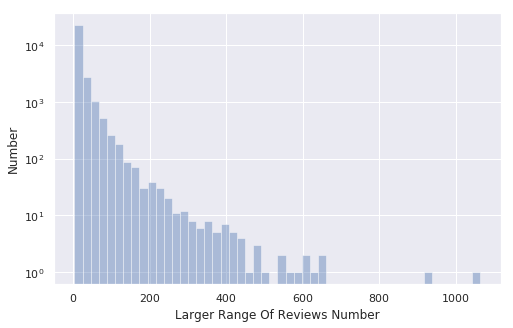

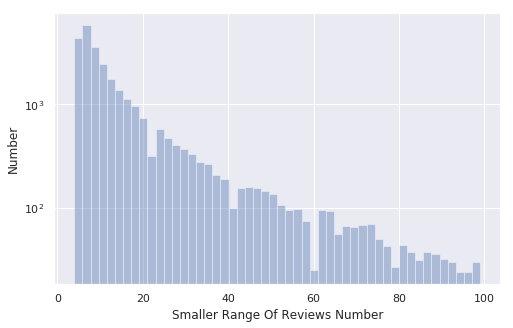

In [29]:
# for home and kitchen products
distribution_products_reviews(home_reviews)

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
In home and kitchen category, most of the products have fewer than 20 reviews.<br>
    
</font>
</div>

In [30]:
# Distribution of number of the reviews of the users  
def distribution_users_reviews(df):
    df_num = df.groupby('reviewerID').count().sort_values(by='asin',ascending = False)
    
    # display the distribution
    plt.figure(figsize=(8,5))
    ax = sns.distplot(df_num['asin'],kde=False, rug=False,hist_kws={'log':True})
    ax.set_xlabel('Larger Range Of Reviews Number')
    ax.set_ylabel('Number')
    
    plt.figure(figsize=(8,5))
    df_num100 = df_num[df_num['asin']<100]
    ax = sns.distplot(df_num100['asin'],kde=False, rug=False,hist_kws={'log':True})
    ax.set_xlabel('Smaller Range Of Reviews Number')
    ax.set_ylabel('Number')

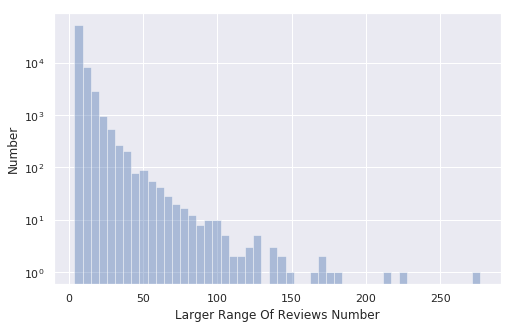

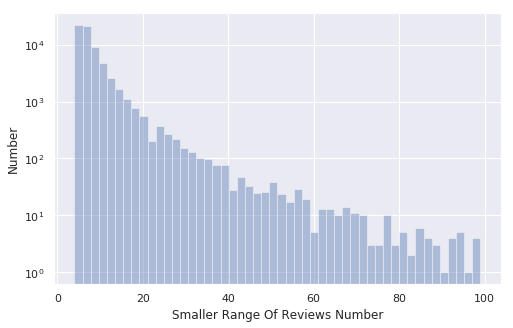

In [31]:
# for home and kitchen products
distribution_users_reviews(home_reviews)

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
In home and kitchen category, most of the users have fewer than 20 reviews.<br>
    
</font>
</div>

In [32]:
# Distribution of ratings of the item that have largest number of reviews

# for home and kitchen products
home_reviews_num = home_reviews.groupby('asin').count().sort_values(by='reviewerID',ascending = False)
home_reviews_num.head(5)

,reviewerID,helpful,reviewText,overall,unixReviewTime
asin,,,,,
B00006JSUA,1064,1064,1064,1064,1064
B001N07KUE,921,921,921,921,921
B00006IUWA,661,661,661,661,661
B00005B8K5,656,656,656,656,656
B000QFDNP8,634,634,634,634,634


Text(0.5,1,'The Distribution Of Reviews Of One Products')

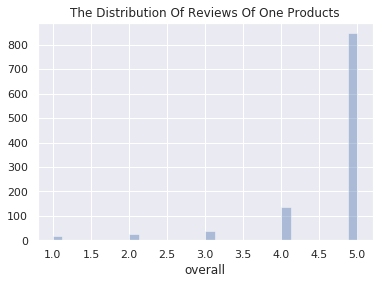

In [33]:
# visualize the distribution of ratings of the item that have largest number of reviews
sns.distplot(home_reviews[home_reviews.asin=='B00006JSUA'].overall,kde=False, rug=False)
plt.title('The Distribution Of Reviews Of One Products')

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
As we can see from the figure above, the distributions of the reviews for the popular products reveals that most of the reviews gave out 5 stars rates.<br>
    
</font>
</div>

### Distribution of ratings from the users that wrote the largest number of reviews

In [34]:
# Distribution of ratings from the users that wrote the largest number of reviews

# for home and kitchen products
home_reviews_num = home_reviews.groupby('reviewerID').count().sort_values(by='asin',ascending = False)
home_reviews_num.head(5)

,asin,helpful,reviewText,overall,unixReviewTime
reviewerID,,,,,
A1IU7S4HCK1XK0,277,277,277,277,277
A25C2M3QF9G7OQ,227,227,227,227,227
A2ZY49IDE6TY5I,216,216,216,216,216
A2NYK9KWFMJV4Y,184,184,184,184,184
A1W415JP5WEAJK,177,177,177,177,177


Text(0.5,1,'The Distribution Of Reviews Of One Reviewer')

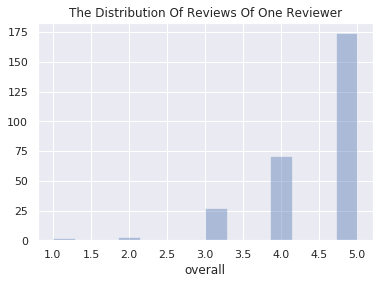

In [35]:
# visualize the distribution of ratings from the users that wrote the largest number of reviews
sns.distplot(home_reviews[home_reviews.reviewerID=='A1IU7S4HCK1XK0'].overall,kde=False, rug=False)
plt.title('The Distribution Of Reviews Of One Reviewer')

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation Description</b><br>
</font>
<font color='black'>
In the home and kitchen category, the reviewers who wrote the most reviews tend to give the positive ratings.<br>
    
</font>
</div>

# Method 1: Detect Spam Reviewers through Abnormal Rating Patterns.


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Method 1: Study the abnormal rating patterns of spam reviewers</b><br>
</font>
<font color='black'>
We would like to quantify the deviation of the rating patterns of spam reviewers from the normal reviewers and rank these deviation to spot the suspicious users. This deviation is represented as statistical unexpectedness - confidence unexpectedness and support unexpectedness respectively.  <br>
We hypothesize that the attribute - user id and ratings are statistical independent. <br>

- General Steps:<br>
   - classify the ratings into three classes: positive, neutral and negative <br>
   - compute the confidence unexpectedness(CU)and support unexpectedness(SU) for each user in each class<br>
   - sum of the cu and su in three classes for each user and rank the users in descent order to filter top ones as potential spam reviewers<br>
</font>
</div>

## Compute Unexpectedness 
The confidence unexpectedness is defined according to conditional probability

In [36]:
# since the attribute user id is assumed to be statistical independent to ratings
# we extracted these two attributes and the products id for studying the one condition pattern 
home_independent_data=home_reviews[['reviewerID','asin','overall']]

In [38]:
# define a function to classify the ratings into three classes
# the ratings that are higher than 3 stars are assigned as positive class
# the ratings that equal to 3 stars are assigned as neutral class
# the ratings that are lower than 3 stars are assigned as negative class
def assign_class(overall):
    if overall==5:
        return 'Positive'
    if overall==3 or overall==4:
        return 'Neutral'
    if overall<3:
        return 'Negative'

In [39]:
# classify the ratings into three classes according to the rules above
home_independent_data.overall=home_independent_data.overall.apply(assign_class)

In [40]:
# define a function to compute the probability of each rating class: P(Ri)
def compute_condional_prop(group):
    p_pos=(group.overall=='Positive').sum()/(group.overall.count())
    p_neu=(group.overall=='Neutral').sum()/(group.overall.count())
    p_neg=(group.overall=='Negative').sum()/(group.overall.count())
    return pd.Series([p_pos,p_neu,p_neg],index=['P_pos','P_neu','P_neg'])

In [41]:
#compute p(Ri) for each class
P_pos=(home_independent_data['overall']=='Positive').sum()/home_independent_data.overall.count()
P_neu=(home_independent_data['overall']=='Neutral').sum()/home_independent_data.overall.count()
P_neg=(home_independent_data['overall']=='Negative').sum()/home_independent_data.overall.count()
print('P(pos)= ',P_pos, '  P(neu)= ',P_neu, '  P(neg)', P_neg)

P(pos)=  0.633895834013339   P(neu)=  0.27294520423743257   P(neg) 0.09315896174922841


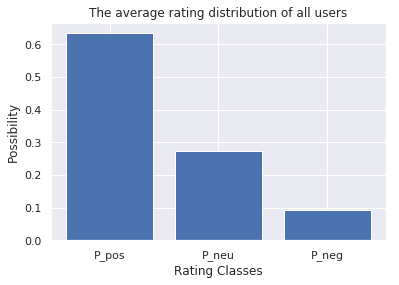

In [42]:
#plot the distribution of P(Ri)
plt.bar(['P_pos','P_neu','P_neg'],[P_pos,P_neu,P_neg])
plt.title("The average rating distribution of all users")
plt.xlabel('Rating Classes')
plt.ylabel('Possibility')
plt.show()

In [43]:
# compute the probability of each rating class for each user : P(c_i|a_jk)
home_rating_distribution=home_independent_data.groupby(by=['reviewerID']).apply(compute_condional_prop)

In [44]:
# check the results we obtain from above - the rating distribution for each user in each class
home_rating_distribution.head()

,P_pos,P_neu,P_neg
reviewerID,,,
A0002382258OFJJ2UYNTR,1.000000,0.000000,0.000000
A0010876CNE3ILIM9HV0,0.571429,0.285714,0.142857
A00473363TJ8YSZ3YAGG9,0.250000,0.750000,0.000000
A00593903MCE5GXTAGGNL,1.000000,0.000000,0.000000
A0145698H8AAYMRXLBD8,0.800000,0.200000,0.000000


In [50]:
# compute the confidence unexpectedness (CU) for each class
home_cu=pd.DataFrame()
home_cu['pos_cu']=(home_rating_distribution['P_pos']-P_pos)/P_pos
home_cu['neu_cu']=(home_rating_distribution['P_neu']-P_neu)/P_neu
home_cu['neg_cu']=(home_rating_distribution['P_neg']-P_neg)/P_neg

In [51]:
# check the results- CU, we obtain from above
home_cu.head()

,pos_cu,neu_cu,neg_cu
reviewerID,,,
A0002382258OFJJ2UYNTR,0.577546,-1.000000,-1.000000
A0010876CNE3ILIM9HV0,-0.098545,0.046783,0.533477
A00473363TJ8YSZ3YAGG9,-0.605613,1.747804,-1.000000
A00593903MCE5GXTAGGNL,0.577546,-1.000000,-1.000000
A0145698H8AAYMRXLBD8,0.262037,-0.267252,-1.000000


## Compute Support Unexpectedness

The support unexpectedness is defined according to joint probability.

In [52]:
# compute the number of reviewers in home and kitchen category
home_reviwers_num = len(set(home_independent_data.reviewerID))

# compute the number of all the reviews in home and kitchen category
home_total_num = home_independent_data.shape[0]

# compute the expectation of each class
exp_pos = P_pos /home_reviwers_num
exp_neu = P_neu /home_reviwers_num
exp_neg = P_neg /home_reviwers_num

# define a function to compute the support unexpectedness (SU) of each class
def compute_support(bag):
    pos_supp = ((bag[bag.overall=='Positive'].shape[0]/home_total_num)-exp_pos)/exp_pos
    neu_supp = ((bag[bag.overall=='Neutral'].shape[0]/home_total_num)-exp_neu)/exp_neu
    neg_supp = ((bag[bag.overall=='Negative'].shape[0]/home_total_num)-exp_neg)/exp_neg
    return pd.Series(data=[pos_supp, neu_supp, neg_supp],index=['pos_su','neu_su','neg_su'])

# compute the SU for each user in each class
home_su = home_independent_data.groupby('reviewerID').apply(compute_support)

In [53]:
# check the results we obtain above : the SU for each user in each class
home_su.head()

,pos_su,neu_su,neg_su
reviewerID,,,
A0002382258OFJJ2UYNTR,-0.048565,-1.000000,-1.000000
A0010876CNE3ILIM9HV0,-0.238852,-0.116144,0.294799
A00473363TJ8YSZ3YAGG9,-0.429139,2.977352,-1.000000
A00593903MCE5GXTAGGNL,1.664018,-1.000000,-1.000000
A0145698H8AAYMRXLBD8,-0.238852,-0.558072,-1.000000


In [54]:
# combine the results of CU and SU we have by now into one dataframe
home_cu_su=home_cu.merge(home_su,left_index=True,right_index=True)

In [55]:
# show the results of the combining dataframe : CU+SU
home_cu_su.head()

,pos_cu,neu_cu,neg_cu,pos_su,neu_su,neg_su
reviewerID,,,,,,
A0002382258OFJJ2UYNTR,0.577546,-1.000000,-1.000000,-0.048565,-1.000000,-1.000000
A0010876CNE3ILIM9HV0,-0.098545,0.046783,0.533477,-0.238852,-0.116144,0.294799
A00473363TJ8YSZ3YAGG9,-0.605613,1.747804,-1.000000,-0.429139,2.977352,-1.000000
A00593903MCE5GXTAGGNL,0.577546,-1.000000,-1.000000,1.664018,-1.000000,-1.000000
A0145698H8AAYMRXLBD8,0.262037,-0.267252,-1.000000,-0.238852,-0.558072,-1.000000


In [56]:
# Sum of the CU in each class as the final CU values for each user, save the results in the column named 'cu_score'
home_cu_su['cu_score']=home_cu_su['pos_cu']+home_cu_su['neu_cu']+home_cu_su['neg_cu']

# Sum of the SU in each class as the final SU values for each user, save the results in the column named 'su_score'
home_cu_su['su_score']=home_cu_su['pos_su']+home_cu_su['neu_su']+home_cu_su['neg_su']

In [57]:
# check the results we get from above
home_cu_su.head()

,pos_cu,neu_cu,neg_cu,pos_su,neu_su,neg_su,cu_score,su_score
reviewerID,,,,,,,,
A0002382258OFJJ2UYNTR,0.577546,-1.000000,-1.000000,-0.048565,-1.000000,-1.000000,-1.422454,-2.048565
A0010876CNE3ILIM9HV0,-0.098545,0.046783,0.533477,-0.238852,-0.116144,0.294799,0.481715,-0.060197
A00473363TJ8YSZ3YAGG9,-0.605613,1.747804,-1.000000,-0.429139,2.977352,-1.000000,0.142191,1.548213
A00593903MCE5GXTAGGNL,0.577546,-1.000000,-1.000000,1.664018,-1.000000,-1.000000,-1.422454,-0.335982
A0145698H8AAYMRXLBD8,0.262037,-0.267252,-1.000000,-0.238852,-0.558072,-1.000000,-1.005215,-1.796924


In [58]:
# set the top 10% ranking users as the suspicious spam reviewers
sus_threshold=int(0.1*home_cu_su.shape[0])
sus_users=home_cu_su.sort_values(by=['cu_score','su_score'],ascending=False).iloc[:sus_threshold]
normal_users=home_cu_su.sort_values(by=['cu_score','su_score'],ascending=False).iloc[sus_threshold:]

In [59]:
# check the result of the suspicious users we found by now
sus_users.head()

,pos_cu,neu_cu,neg_cu,pos_su,neu_su,neg_su,cu_score,su_score
reviewerID,,,,,,,,
A1LUPQJLN3BRDO,-1.0,-1.0,9.73434,-1.0,-1.0,14.537587,7.73434,12.537587
A2UW6M4S2W8QOC,-1.0,-1.0,9.73434,-1.0,-1.0,14.537587,7.73434,12.537587
A13HOP8991UOLC,-1.0,-1.0,9.73434,-1.0,-1.0,8.063592,7.73434,6.063592
A23YJ2MIV0EKI6,-1.0,-1.0,9.73434,-1.0,-1.0,8.063592,7.73434,6.063592
A1KJM9PS3JJH8P,-1.0,-1.0,9.73434,-1.0,-1.0,6.768794,7.73434,4.768794


In [60]:
# check the result of the normal users we found by now
normal_users.head()

,pos_cu,neu_cu,neg_cu,pos_su,neu_su,neg_su,cu_score,su_score
reviewerID,,,,,,,,
A3PZ7WCTEY6AG0,-0.211227,-0.389377,2.578113,-0.429139,-0.558072,1.589598,1.97751,0.602387
A3QBXZDK9A8AVE,-0.211227,-0.389377,2.578113,-0.429139,-0.558072,1.589598,1.97751,0.602387
A3QQPNJCLW6ROA,-0.211227,-0.389377,2.578113,-0.429139,-0.558072,1.589598,1.97751,0.602387
A3R3OQIN6R3P8T,-0.211227,-0.389377,2.578113,-0.429139,-0.558072,1.589598,1.97751,0.602387
A3R86H34VWNVA6,-0.211227,-0.389377,2.578113,-0.429139,-0.558072,1.589598,1.97751,0.602387


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Visualize the top rank suspicious reviewer </b><br>
</font>
<font color='black'>
We try to visualize the top rank suspicious reviewers and oberserve its difference from the normal ones.<br>
</font>
</div>

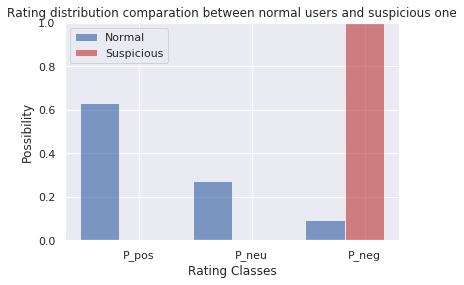

In [63]:
# The comparation of rating distributions between most suspicious user and average users
index = np.arange(3)  
bar_width = 0.35  
opacity = 0.7  
plt.bar(index, [P_pos,P_neu,P_neg], bar_width,alpha=opacity, color='b',label= 'Normal')  
plt.bar(index + bar_width, home_rating_distribution.loc['A1LUPQJLN3BRDO'], bar_width,alpha=opacity,color='r',label='Suspicious')  
plt.xticks(index + bar_width, ('P_pos', 'P_neu', 'P_neg'))  
plt.title("Rating distribution comparation between normal users and suspicious one")
plt.xlabel('Rating Classes')
plt.ylabel('Possibility')
plt.ylim(0,1)  
plt.legend()
plt.show()

In [64]:
# sample the suspicious users to visualize
sus_users_samples=sus_users.sample(frac=0.01)

# sample the normal users to visualize
normal_users_samples=normal_users.sample(frac=0.01)

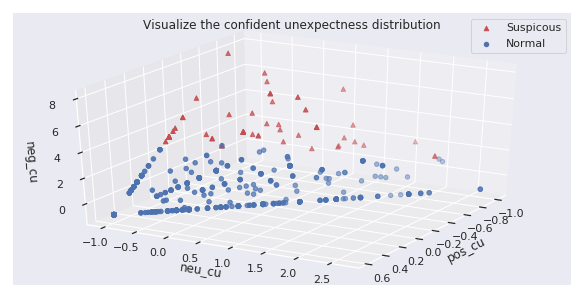

In [68]:
# Visualize the suspicious users and normal users computed by CU 
# the red dots represent the suspicious users, the blue dots represent the normal users
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sus_users_samples['pos_cu'],sus_users_samples['neu_cu'],sus_users_samples['neg_cu'],c='r',marker='^',label='Suspicous')
ax.scatter(normal_users_samples['pos_cu'],normal_users_samples['neu_cu'],normal_users_samples['neg_cu'],c='b',marker='o',label="Normal")
ax.view_init(30,30)
ax.set_title('Visualize the confident unexpectness distribution')
ax.set_xlabel('pos_cu')
ax.set_ylabel('neu_cu')
ax.set_zlabel('neg_cu')
ax.legend()
plt.show()

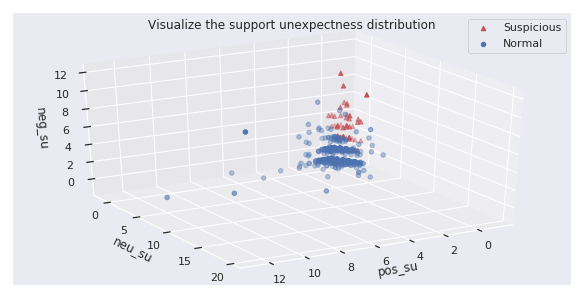

In [67]:
# Visualize the suspicious users and normal users computed by SU
# the red dots represent the suspicious users, the blue dots represent the normal users
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sus_users_samples['pos_su'],sus_users_samples['neu_su'],sus_users_samples['neg_su'],c='r',marker='^',label='Suspicious')
ax.scatter(normal_users_samples['pos_su'],normal_users_samples['neu_su'],normal_users_samples['neg_su'],c='b',marker='o',label='Normal')
ax.view_init(30,60)
ax.set_title('Visualize the support unexpectness distribution')
ax.set_xlabel('pos_su')
ax.set_ylabel('neu_su')
ax.set_zlabel('neg_su')
ax.legend()
plt.show()

# Method 2: Detect Spam Reviewers through Unsupervised Clustering

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Method 2: reviewers and reviews clustering by unsupervised learning </b><br>
</font>
<font color='black'>
    <br>
Intuitive idea: the features we design can reflect the behaviors of the spam and non-spam reviewers as well as the characteristics of fake and non-fake reviews thus we can split the reviewers and reviews into spam and non-spam clustering by unsupervised learning method.
We apply the unsupervised learning method to find out the spam reviewers by self-designed features especially for spam reviewers and fake reviews respectively.<br>
</font>
</div>

## Feature Engineering

### Convert Text Sentence to Vector 

In [69]:
#sentence2vec
nlp = spacy.load('en')

# Sentence to Vector 
def sentence2vector(text):
    return nlp(text).vector

In [70]:
# home_reviews['reviewVec']=home_reviews.reviewText.apply(sentence2vector)
# pickle.dump(home_reviews,open('home_reviews_textVec.pkl','wb'))
home_reviews_textVec=pickle.load(open('home_reviews_textVec.pkl','rb'))

In [71]:
# check the results of the reviews data after converting into vector
home_reviews_textVec.head()

,reviewerID,asin,helpful,reviewText,overall,unixReviewTime,reviewVec
0,APYOBQE6M18AA,0615391206,"[0, 0]",My daughter wanted this book and the price on ...,5.0,1382140800,"[0.14266632, 0.040547352, 0.78923875, 1.961626..."
1,A1JVQTAGHYOL7F,0615391206,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,1403049600,"[0.42623562, 0.28558293, 1.0666791, 1.1686757,..."
2,A3UPYGJKZ0XTU4,0615391206,"[26, 27]",There is no shortage of pop recipes available ...,4.0,1367712000,"[0.33166683, 0.3857316, 0.13150564, 0.8163318,..."
3,A2MHCTX43MIMDZ,0615391206,"[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,1312416000,"[0.12381068, -0.17305964, 0.49680334, 1.404797..."
4,AHAI85T5C2DH3,0615391206,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,1402099200,"[0.14035076, -0.090854086, 0.57210714, 1.25145..."


### Comvert unixReviewTime to python datetime

In [72]:
# define a function to convert unixReviewTime to python datetime
def unixRevTime2pythonTime(unix_time):
    pythonTime=date.fromtimestamp(unix_time)
    return pythonTime

In [73]:
# convert the unixReviewTime to python datetime
home_reviews_textVec.unixReviewTime=home_reviews.unixReviewTime.apply(unixRevTime2pythonTime)

# change the column's name of unixReviewTime into PythonTime
home_reviews_textVec.rename(columns={"unixReviewTime":"PythonTime"},inplace=True)

In [74]:
# check the results of the reviews data after changing the unix time into python time
home_reviews_textVec.head()

,reviewerID,asin,helpful,reviewText,overall,PythonTime,reviewVec
0,APYOBQE6M18AA,0615391206,"[0, 0]",My daughter wanted this book and the price on ...,5.0,2013-10-19,"[0.14266632, 0.040547352, 0.78923875, 1.961626..."
1,A1JVQTAGHYOL7F,0615391206,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,2014-06-18,"[0.42623562, 0.28558293, 1.0666791, 1.1686757,..."
2,A3UPYGJKZ0XTU4,0615391206,"[26, 27]",There is no shortage of pop recipes available ...,4.0,2013-05-05,"[0.33166683, 0.3857316, 0.13150564, 0.8163318,..."
3,A2MHCTX43MIMDZ,0615391206,"[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,2011-08-04,"[0.12381068, -0.17305964, 0.49680334, 1.404797..."
4,AHAI85T5C2DH3,0615391206,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,2014-06-07,"[0.14035076, -0.090854086, 0.57210714, 1.25145..."


## Clustering by reviewer features

### Computing Features: 
- Reviewer Features:
 - Review Text Similarity (RTS)
 - Review Interval (RI)
 - First Reviewer Frequency (FRF)
 - Maximal Number of Reviews Per Day (MNR)

In [75]:

# Convert unixReviewTime to python datetime
def unixRevTime2pythonTime(unix_time):
    pythonTime=date.fromtimestamp(unix_time)
    return pythonTime

# compute Review Text Similarity RTS
'''
group: group by reviewerID
'''
def compute_similarity(group):
    max_RTS=0;
    vec = group.reviewVec
    for i in range(len(vec)-1):
        for j in range(i+1,len(vec)): 
            tmp=1-distance.cosine(vec.iloc[i],vec.iloc[j])
            if tmp>max_RTS:
                max_RTS=tmp
    return max_RTS

#compute Review Interval (RI)
'''
group: group by reviewerID

'''
def compute_RI(group):

    latest_t=group.PythonTime.max()
    first_t=group.PythonTime.min()
    t=(latest_t-first_t).days
    threshold=28
    if t>threshold:
        return 0;
    else:
        return (1-(t/threshold))

    
#compute First Reviewes Number
'''
group: group by asin

'''
def compute_FRN(group):
    threshold=3
    for i in range(threshold):
        reviewer_features.FRN.loc[group.reviewerID.iloc[i]]+=1

In [76]:
#group the reviews by reviewerID
home_reviews_grouped=home_reviews_textVec.groupby(by=['reviewerID'])

In [77]:
#group the reviews by productID
home_reviews_grouped_id=home_reviews_textVec.groupby(by=['asin'])

In [78]:
# Compute Maximal Number of Reviews per day
reviewer_features=pd.DataFrame(home_reviews_grouped.PythonTime.value_counts()\
                               .groupby(level=0).apply(max))
reviewer_features.rename(columns={'PythonTime':'MNR'},inplace=True)

In [79]:
# compute Review Text Similiarity RTS
reviewer_features['RTS']=home_reviews_grouped.apply(compute_similarity)

In [80]:
#compute Review Interval (RI)
reviewer_features['RI']=home_reviews_grouped.apply(compute_RI)

In [81]:
#compute compute First Reviewes Number
reviewer_features['FRN']=np.zeros((len(reviewer_features),1))
#sort the review time group by product and found out those who write review first.
sorted_reviewTime_table=home_reviews_grouped_id.apply(pd.DataFrame.sort_values,'PythonTime')
#Compute_FRN: 
sorted_reviewTime_table.groupby(level=0).apply(compute_FRN)

""


In [82]:
reviewer_features.head()

,MNR,RTS,RI,FRN
reviewerID,,,,
A0002382258OFJJ2UYNTR,3,0.870572,0.000000,1.0
A0010876CNE3ILIM9HV0,3,0.953200,0.000000,1.0
A00473363TJ8YSZ3YAGG9,4,0.920133,0.000000,1.0
A00593903MCE5GXTAGGNL,12,0.889532,0.000000,0.0
A0145698H8AAYMRXLBD8,4,0.869029,0.892857,0.0


### Clustering of the spam reviewers and non-spam reviewers

### Normalize the training data

In [87]:
#Normalize the data
reviewer_features_normal = (reviewer_features - reviewer_features.mean()) / (reviewer_features.max()-reviewer_features.min())

In [88]:
reviewer_features_normal.head()

,MNR,RTS,RI,FRN
reviewerID,,,,
A0002382258OFJJ2UYNTR,0.000166,-0.094574,-0.069376,-0.002605
A0010876CNE3ILIM9HV0,0.000166,0.069283,-0.069376,-0.002605
A00473363TJ8YSZ3YAGG9,0.023422,0.003709,-0.069376,-0.002605
A00593903MCE5GXTAGGNL,0.209469,-0.056974,-0.069376,-0.012128
A0145698H8AAYMRXLBD8,0.023422,-0.097633,0.823481,-0.012128


### K-means model

In [95]:
kmeans = KMeans(n_clusters=2).fit(reviewer_features_normal.values)
# Format results as a DataFrame
reviewer_features['label_kmeans']=kmeans.labels_

In [96]:
# Show the number of suspicious reviewer
print(" Number of suspicious reviewer: ",reviewer_features.label_kmeans.sum())

 Number of suspicious reviewer:  4685


### Gaussian Mixture Model

In [97]:
GMM=GaussianMixture(n_components=2)
GMM.fit(reviewer_features_normal.values)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [98]:
reviewer_features['label_GMM']=GMM.predict(reviewer_features_normal.values)

In [99]:
# Show the number of suspicious reviewer
print(" Number of suspicious reviewer: ",reviewer_features.label_GMM.sum())

 Number of suspicious reviewer:  5831


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Show the Propobility difference of GMM </b><br>
</font>
<font color='black'>
    <br>We try to visualize the histogram for the Difference between the Probabilities of Two Classes 
</font>
</div>

In [101]:
#Compute Propobility for two Gaussians
GMM_prop=pd.DataFrame(GMM.predict_proba(reviewer_features_normal.values))
GMM_prop=GMM_prop.rename(columns={0:"Normal",1:"Sus"})

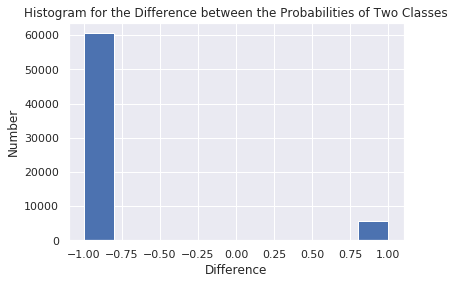

In [102]:
plt.hist(GMM_prop['Sus']-GMM_prop['Normal'])
plt.xlabel('Difference')
plt.ylabel('Number')
plt.title('Histogram for the Difference between the Probabilities of Two Classes')
plt.show()

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>The log version</b><br>
</font>

</div>

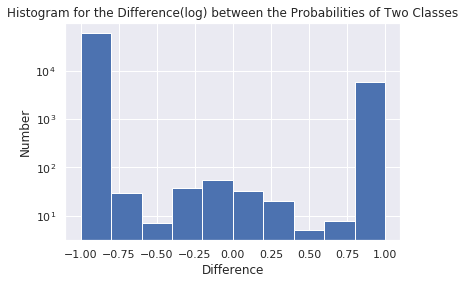

In [103]:
plt.hist(GMM_prop['Sus']-GMM_prop['Normal'],log=True)
plt.xlabel('Difference')
plt.ylabel('Number')
plt.title('Histogram for the Difference(log) between the Probabilities of Two Classes')
plt.show()

### Compute the intersection bewteen K-means and GMM

In [153]:
set_kmeans_1=set(reviewer_features.index[reviewer_features.label_kmeans==1])
set_GMM_1=set(reviewer_features.index[reviewer_features.label_GMM==1])

In [154]:
# compute the number of the suspicious users
print("The intersection of those two models: ",len(set_kmeans_1.intersection(set_GMM_1)))

The intersection of those two models:  4685


## Clustering by review features

### Computing Features: 
- Review Features:
 - Review Repetition (RR)
 - Rating Bias (RB)
 - Extreme Rating (ER)
 - Early Post (EP)

In [104]:
home_review_features = home_reviews_textVec[['reviewerID','asin','reviewVec','overall','PythonTime']]

In [105]:
home_review_features.head()

,reviewerID,asin,reviewVec,overall,PythonTime
0,APYOBQE6M18AA,0615391206,"[0.14266632, 0.040547352, 0.78923875, 1.961626...",5.0,2013-10-19
1,A1JVQTAGHYOL7F,0615391206,"[0.42623562, 0.28558293, 1.0666791, 1.1686757,...",5.0,2014-06-18
2,A3UPYGJKZ0XTU4,0615391206,"[0.33166683, 0.3857316, 0.13150564, 0.8163318,...",4.0,2013-05-05
3,A2MHCTX43MIMDZ,0615391206,"[0.12381068, -0.17305964, 0.49680334, 1.404797...",5.0,2011-08-04
4,AHAI85T5C2DH3,0615391206,"[0.14035076, -0.090854086, 0.57210714, 1.25145...",4.0,2014-06-07


In [106]:
# define a function to compute the confidence interval of the rating distribution
def confidence_interval(ratings, level):
    lower_q = (1-level)/2
    return ratings.groupby('asin').apply(lambda x: [x.overall.quantile(lower_q),x.overall.quantile(1-lower_q)])

# define a function to initially label the suspicious reviewers
# This returns the Rating Bias feature
def inspect_review(df, level):
    df_ci = confidence_interval(df, level)
    df_ci = pd.DataFrame(df_ci).reset_index()
    df_ci.columns = ['asin','ci']
    df_ci = df.merge(df_ci, left_on='asin', right_on='asin')
    
    # the reviews whose rate is out of the confidence interval were regarded as suspicious and labeled 1, otherwise labeled 0
    df_ci['RB'] = df_ci.apply(lambda x: 0 if x.overall>=x.ci[0] and x.overall<=x.ci[1] else 1, axis=1)
    
    return df_ci.drop(columns=['ci'])

# Compute review repetition
def compute_rr(bag):
    sim = []
    text = bag.reviewVec
    # calculate the maximum distance between two reviews belonging to the same product
    for i in text:
        init = 0
        for j in text:
            if np.all(i==j):
                continue
            else:
                init = np.maximum(1-distance.cosine(i,j), init)
                # threshold
                if init >= 0.9:
                    break
        if init >= 0.9:
            sim.append(1)
        else:
            sim.append(0)
    return pd.DataFrame({'reviewerID':bag.reviewerID,
                         'asin':bag.asin,
                         'RR':sim})

# Compute Early post feature
def compute_ep(bag):
    # suspect if a review comes to early
    time = bag.PythonTime
    etf = []
    for i in time:
        if i == min(time):
            etf.append(1)
        else:
            etf.append(0)
    return pd.DataFrame({'reviewerID':bag.reviewerID,
                         'asin':bag.asin,
                         'EP':etf})


In [107]:
# Generate all features for reviews
def review_feature(df, level):
    #compute review repetition
    sim = df.groupby('asin').apply(compute_rr)
    sim = sim.set_index(['reviewerID','asin'])
    
    #compute early post
    etf = df.groupby('asin').apply(compute_ep)
    etf = etf.set_index(['reviewerID','asin'])
    
    #decide the rating bias
    df = inspect_review(df, level)
    
    #generate extreme rating feature
    df['ER'] = df.overall.apply(lambda x: 1 if x==5 or x==1 else 0)
    
    df_index = df.set_index(['reviewerID','asin'])
    df_index = df_index.merge(sim, left_index=True, right_index=True)
    df_index = df_index.merge(etf, left_index=True, right_index=True)
    
    return df_index.reset_index()


In [108]:
home_review_features=review_feature(home_review_features,0.8)
pickle.dump(home_review_features,open('home_review_features.pkl','wb'))
home_review_features=pickle.load(open('home_review_features.pkl','rb'))
home_review_features.head()

,reviewerID,asin,reviewVec,overall,PythonTime,RB,ER,RR,EP
0,APYOBQE6M18AA,0615391206,"[0.14266632, 0.040547352, 0.78923875, 1.961626...",5.0,2013-10-19,0,1,0,0
1,A1JVQTAGHYOL7F,0615391206,"[0.42623562, 0.28558293, 1.0666791, 1.1686757,...",5.0,2014-06-18,0,1,0,0
2,A3UPYGJKZ0XTU4,0615391206,"[0.33166683, 0.3857316, 0.13150564, 0.8163318,...",4.0,2013-05-05,0,0,0,0
3,A2MHCTX43MIMDZ,0615391206,"[0.12381068, -0.17305964, 0.49680334, 1.404797...",5.0,2011-08-04,0,1,1,1
4,AHAI85T5C2DH3,0615391206,"[0.14035076, -0.090854086, 0.57210714, 1.25145...",4.0,2014-06-07,0,0,1,0


In [109]:
home_review_features.drop(columns=['reviewVec','overall','PythonTime'],inplace=True)

In [110]:
home_review_features.set_index(['reviewerID','asin'],inplace=True)

In [117]:
home_review_features.head()

,,RB,ER,RR,EP,label_kmeans
reviewerID,asin,,,,,
APYOBQE6M18AA,0615391206,0,1,0,0,0
A1JVQTAGHYOL7F,0615391206,0,1,0,0,0
A3UPYGJKZ0XTU4,0615391206,0,0,0,0,0
A2MHCTX43MIMDZ,0615391206,0,1,1,1,1
AHAI85T5C2DH3,0615391206,0,0,1,0,1


### Clustering of the fake reviews and non-fake reviews

## K-means model

In [112]:
kmeans_review = KMeans(n_clusters=2).fit(home_review_features.values)
# Format results as a DataFrame
home_review_features['label_kmeans']=kmeans_review.labels_

In [115]:
print('Fake reviews: ',min(home_review_features.label_kmeans.sum(),
             (len(home_review_features)-home_review_features.label_kmeans.sum())))

Fake reviews:  213590


### Gaussian Mixture Model

In [118]:
GMM_review=GaussianMixture(n_components=2)
GMM_review.fit(home_review_features.drop(columns=['label_kmeans']).values)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [119]:
home_review_features['label_GMM']=GMM.predict(home_review_features.drop(columns=['label_kmeans']).values)

In [120]:
print('Fake reviews: ',min(home_review_features.label_GMM.sum(),
             (len(home_review_features)-home_review_features.label_GMM.sum())))

Fake reviews:  11415


In [129]:
home_review_features.reset_index()
home_review_features.head()

,reviewerID,asin,RB,ER,RR,EP,label_kmeans,label_GMM
0,APYOBQE6M18AA,0615391206,0,1,0,0,0,1
1,A1JVQTAGHYOL7F,0615391206,0,1,0,0,0,1
2,A3UPYGJKZ0XTU4,0615391206,0,0,0,0,0,1
3,A2MHCTX43MIMDZ,0615391206,0,1,1,1,1,1
4,AHAI85T5C2DH3,0615391206,0,0,1,0,1,1


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Compute fake reviewers through fake reviews </b><br>
</font>
<font color='black'>
    <br>We compute the fake reviewers by detected fake reviews. Intuitive idea: those who wrote many fake reviews are suspicious reviews. Therefore, we compute for one user: the ratio of fake reviews and all reviews the user wrote. If 80% reviews are fake then we think this user is a spam. 80% here is refer to suspicious ratio(sus_ratio) of a user.
</font>
</div>

In [134]:
#Compute sus_ratio for kmeans and GMM
home_sus_ratio=pd.DataFrame(home_review_features.groupby(by=['reviewerID']).label_kmeans.sum())
home_sus_ratio['label_GMM']=pd.DataFrame(home_review_features.groupby(by=['reviewerID']).label_GMM.sum())
home_sus_ratio['sus_ratio_kmeans']=home_sus_ratio['label_kmeans']/home_review_features.groupby(by=['reviewerID']).label_kmeans.count()
home_sus_ratio['sus_ratio_GMM']=(1-(home_sus_ratio['label_GMM']/home_review_features.groupby(by=['reviewerID']).label_GMM.count()))

In [157]:
home_sus_ratio.head()

,label_kmeans,sus_ratio_kmeans,label_GMM,sus_ratio_GMM
reviewerID,,,,
A0002382258OFJJ2UYNTR,0,0.000000,5,0.0
A0010876CNE3ILIM9HV0,4,0.571429,7,0.0
A00473363TJ8YSZ3YAGG9,7,0.583333,12,0.0
A00593903MCE5GXTAGGNL,0,0.000000,14,0.0
A0145698H8AAYMRXLBD8,1,0.200000,5,0.0


In [177]:
#Compute fake reviews list
set_kmeans_2=set(home_sus_ratio.index[home_sus_ratio.sus_ratio_kmeans>0.8])
set_GMM_2=set(home_sus_ratio.index[home_sus_ratio.sus_ratio_GMM>0.8])

In [178]:
print('The number of fake reviewers by k-means',len(set_kmeans_2))
print('The number of fake reviewers by GMM',len(set_GMM_2))

The number of fake reviewers by k-means 16671
The number of fake reviewers by GMM 1


In [166]:
# compute the number of the suspicious users
print("The intersection of those two models: ",len(set_kmeans_2.intersection(set_GMM_2)))

The intersection of those two models:  0


<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Why GMM fail in second case </b><br>
</font>
<font color='black'>
    <br>In second clustering, we cluster the reviews by kmeans and GMM. But the review features we design is binary features. Therefore,GMM models may not fit for these data. We only consider K-means for review clustering
</font>
</div>

## Compute the intersection of clustering by reviewers and clustering by reviews

In [167]:
print("The intersection between clustering by reviewers and clustering by reviews: ",
     len(set_kmeans_1.intersection(set_kmeans_2)))

The intersection between clustering by reviewers and clustering by reviews:  522


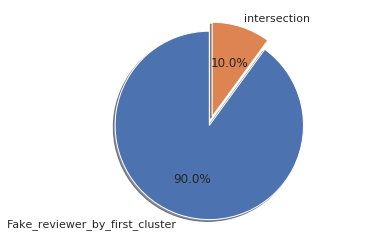

In [172]:
labels = 'Fake_reviewer_by_first_cluster','intersection'
sizes = [4680,522]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation </b><br>
</font>
<font color='black'>
    <br> We calculate the intersection of two lists. There are $522$ users discovered by two clustering methods in common, and the percentage of overlapping between two lists is around $10.1\%$.
</font>
</div>

Text(0.5,1,'Histogram of Percentage of Fake Reviews for Reviewers')

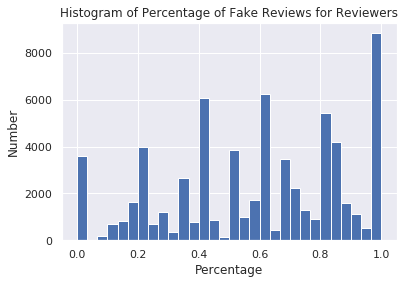

In [173]:
#Draw a histogram about Histogram of Percentage of Fake Reviews for Reviewers
plt.hist(home_sus_ratio['sus_ratio_kmeans'],bins=30)
plt.xlabel('Percentage')
plt.ylabel('Number')
plt.title('Histogram of Percentage of Fake Reviews for Reviewers')

<div class="alert alert-block alert-warning">
<font color='#B8860B'>
<b>Observation </b><br>
</font>
<font color='black'>
    <br> We find that the proportion of users with at least one detected fake review is huge: $94.6\%$. Intuitively, the ideal histogram of the percentage of the fake reviews for reviewers should be descending as the percentage goes from $0$ to $1$. However, contradictory figure implies that the clustering of reviews is unconvincing.
</font>
</div>